# Trained model visualisation and evaluation

In [2]:
import os
import sys
import wfdb
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('/workspaces/ECG-ML-Challenge/notebooks/', "..")))
from src.dataset.processing import aux2vec
from src import config
from src.visualization import plot_ecg

import numpy as np

Signal: ['MLII', 'V1']
Frequency: 360


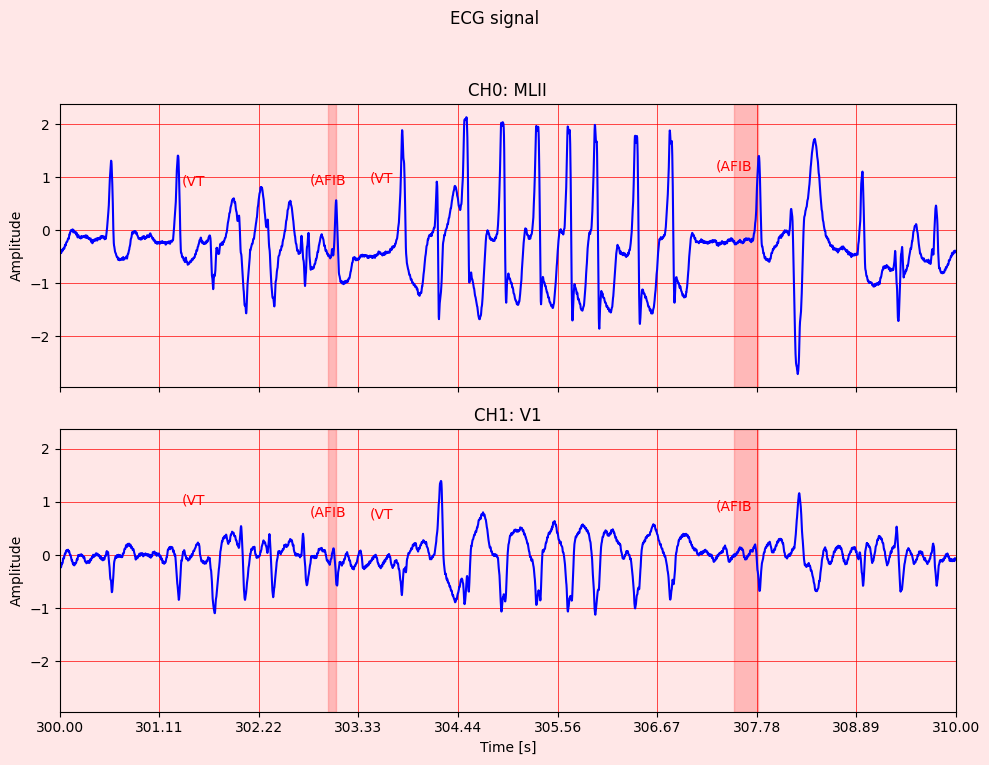

In [3]:
signal = '203'
t_start = 300
t_end = 310

record = wfdb.rdrecord(os.path.join(config.RAW_DATA_DIR, 'mitdb', signal))
annotation = wfdb.rdann(os.path.join(config.RAW_DATA_DIR, 'mitdb', signal), 'atr')
print(f'Signal: {record.sig_name}')
print(f'Frequency: {record.fs}')
_ = plot_ecg(record, record.fs, t_start=t_start, t_end=t_end, annotation=annotation)

In [ ]:
y = aux2vec(annotation, record.fs, record.sig_len)
plt.plot(np.arange(t_start, t_end, 1/record.fs), y[t_start*record.fs:t_end*record.fs])

In [72]:
import torch
from src.model import models

model_file = 'GPTMultiScaleConvGRUModel_20241119_1920_15_192_0.001.pth'
model = models.GPTMultiScaleConvGRUModel()
model.load_state_dict(torch.load(os.path.join(config.MODELS_DIR, model_file), map_location=torch.device('cpu'), weights_only=True))
model.eval()

GPTMultiScaleConvGRUModel(
  (conv1_1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (shortcut1): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (conv2_1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2_2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2_3): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (shortcut2): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (conv3_1): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3_2): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3_3): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
  (shortcut3): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(192, 128, num_layers=3, batch_first=True, bidirectional=Tr

In [22]:
import wfdb.processing

TRAINED_CHUNK_SIZE = 2000
TRAINED_FS = 250

signals = []
for i in range(record.n_sig):
    signal, _ = wfdb.processing.resample_sig(record.p_signal.T[i, ...], record.fs, TRAINED_FS)
    signals.append(signal)
signal = np.array(signals)

ch, sig_len = signal.shape
print(f'Input signal shape: {signal.shape}')

if sig_len % TRAINED_CHUNK_SIZE != 0:
    padding = TRAINED_CHUNK_SIZE - (sig_len % TRAINED_CHUNK_SIZE)
    print(f"Applying padding of size {padding} to the data.")
    signal = np.pad(signal, ((0, 0), (0, padding)), "constant")
    print(f'Padded signal shape: {signal.shape}')

num_chunks = sig_len // TRAINED_CHUNK_SIZE
chunks = [signal[:, i * TRAINED_CHUNK_SIZE : (i + 1) * TRAINED_CHUNK_SIZE] for i in range(num_chunks)]
print(f'Number of chunks: {len(chunks)}')

Input signal shape: (2, 451388)
Applying padding of size 612 to the data.
Padded signal shape: (2, 452000)
Number of chunks: 225


In [42]:
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

torch.backends.nnpack.enabled = False

idx_start = t_start * TRAINED_FS
idx_end = t_end * TRAINED_FS

chunk_id = idx_start // TRAINED_CHUNK_SIZE + 1

Y = []
for chunk in chunks:
    with torch.no_grad():
        x = torch.tensor(normalize(chunk, axis=1), dtype=torch.float32)
        x = x.squeeze(0)
        y = model(x).numpy()
    Y.append(y)

Y = np.concatenate(Y, axis=1)

print(Y.shape)

(2, 450000)


[41 27]


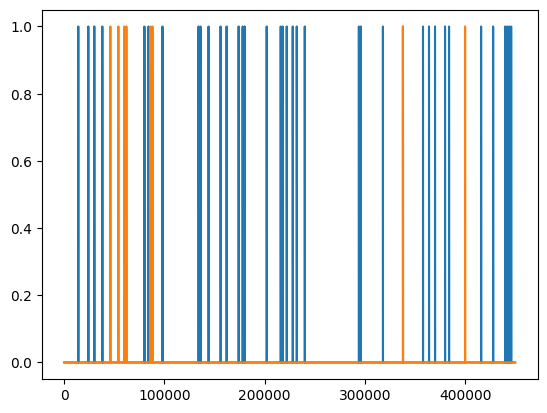

In [65]:
threshold = 0.008
print((Y > threshold).sum(axis=1))
plt.plot(Y.T>threshold)